# Crosswalk Scenario - Reachability Analysis

In [1]:
rng = MersenneTwister(1);

In [3]:
# include("../AutomotivePOMDPs/AutomotivePOMDPs.jl")
using AutomotivePOMDPs

In [4]:
using POMDPs, POMDPToolbox, AutoViz, AutomotiveDrivingModels, Reel, ProgressMeter
using PyPlot

In [5]:
using PyCall
@pyimport stormpy

In [6]:
include("pomdps_to_storm.jl")
include("underlying_mdp.jl")

## Initialize Scenario

In [7]:
env = CrosswalkEnv()
env.obstacles = Vector{ConvexPolygon}[] # remove obstacles
pomdp = SingleOCPOMDP(env = env, no_ped_prob=0.,
                      pos_obs_noise = 0.,
                      vel_obs_noise = 0.); #FO

In [8]:
n_states(pomdp)

10098

## Convert to Storm

In [9]:
mdp = UnderlyingMDP(pomdp)

UnderlyingMDP{AutomotivePOMDPs.SingleOCPOMDP,AutomotivePOMDPs.SingleOCState,AutomotivePOMDPs.SingleOCAction}(AutomotivePOMDPs.SingleOCPOMDP(AutomotivePOMDPs.CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[], AutomotivePOMDPs.CrosswalkParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 100, 0.5, 2.0, 10.0)), VehicleDef(CAR, 4.000, 1.800), VehicleDef(PEDESTRIAN, 1.000, 1.000), 2.0, 1.0, 1.0, 5.0, -5.0, 37.0, 5.0, 0.5, 0.3, 0.0, false, 1.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.95))

In [9]:
# write_storm_mdp(mdp, "crosswalk.tra")

In [10]:
function label_crosswalk(pomdp::SingleOCPOMDP)
    labels = Dict{SingleOCState, String}()
    states = ordered_states(pomdp)
    for s in states
        if s.crash
            labels[s] = "crash"
        elseif s.ego.posG.x >= pomdp.x_goal
            labels[s] = "goal"
        end
    end
    return labels
end  

labels = label_crosswalk(pomdp);

In [11]:
write_storm_labels(mdp, labels, "crosswalk.lab")

In [12]:
tra_file = pwd()*"/crosswalk.tra"
lab_file = pwd()*"/crosswalk.lab"
model = stormpy.build_sparse_model_from_explicit(tra_file, lab_file)

PyObject <stormpy.storage.storage.SparseMdp object at 0x7f73d854cfb8>

In [13]:
println("Results from parsing the model: ")
println("Model type ", model[:model_type])
println("Number of states ", model[:nr_states])
println("Number of transitions ", model[:nr_transitions])
println("Labels ", model[:labeling][:get_labels]())

Results from parsing the model: 
Model type PyObject ModelType.MDP
Number of states 10098
Number of transitions 198696
Labels PyObject {'crash', 'goal'}


In [14]:
property = "Pmax=? [ ! \"crash\" U \"goal\"]"

"Pmax=? [ ! \"crash\" U \"goal\"]"

In [15]:
properties = stormpy.parse_properties(property)

1-element Array{PyCall.PyObject,1}:
 PyObject <stormpy.core.Property object at 0x7f73d854cf80>

In [16]:
result = stormpy.model_checking(model, properties[1], extract_scheduler=true)
@assert result[:result_for_all_states]
@assert result[:has_scheduler]

In [39]:
# Lowest probability of success in the initialstates
d0 = initialstate_distribution(mdp)
init_indices = zeros(Int, length(d0.it))
for (i, s) in enumerate(d0.it)
    init_indices[i] = stateindex(mdp, s)
end
P = get_proba(mdp, result)
initial_proba = P[init_indices]
println("The lowest probability of success is ", minimum(initial_proba), " for initial state ", indmin(initial_proba))
println("The average probability of success is ", sum(initial_proba.*d0.p))

The lowest probability of success is 1.0 for initial state 1
The average probability of success is 1.0000000000000002


## Simulate and visualize scheduler

In [18]:
threshold = 1.0
policy = Scheduler(mdp, result[:scheduler])
P = get_proba(mdp, result)
mask = SafetyMask(mdp, policy, P, threshold);

In [19]:
function get_constraints_stats(mdp::MDP, policy::Scheduler, P::Vector{Float64}, threshold::Float64)
    mask = SafetyMask(mdp, policy, P, threshold);
    fully_constrained_count = 0
    partially_constrained_count = 0
    not_constrained_count = 0
    for s in states(mdp)
        acts = get_safe_actions(mask, s)
        if length(acts) == 1
            fully_constrained_count += 1
        elseif 1 < length(acts) < n_actions(mdp)
            partially_constrained_count += 1
        else 
            not_constrained_count += 1
        end
    end
    fc_part = fully_constrained_count/n_states(mdp)*100
    pc_part = partially_constrained_count/n_states(mdp)*100
    nc_part = not_constrained_count/n_states(mdp)*100
    return fc_part, pc_part, nc_part
end
fc_part, pc_part, nc_part = get_constraints_stats(mdp, policy, P, threshold)
println("Fraction of the state space where actions are fully constrained ", fc_part)
println("Fraction of the state space where actions are partially constrained ", pc_part)
println("Fraction of the state space where actions are not constrained ", nc_part)

Fraction of the state space where actions are fully constrained 100.0
Fraction of the state space where actions are partially constrained 0.0
Fraction of the state space where actions are not constrained 0.0


In [20]:
th_range = 0.99:0.001:1.0
@time res = map(th -> get_constraints_stats(mdp, policy, P, th), th_range)
fc_parts, pc_parts, nc_parts = zip(res...);

 30.165397 seconds (619.81 M allocations: 19.229 GiB, 20.34% gc time)


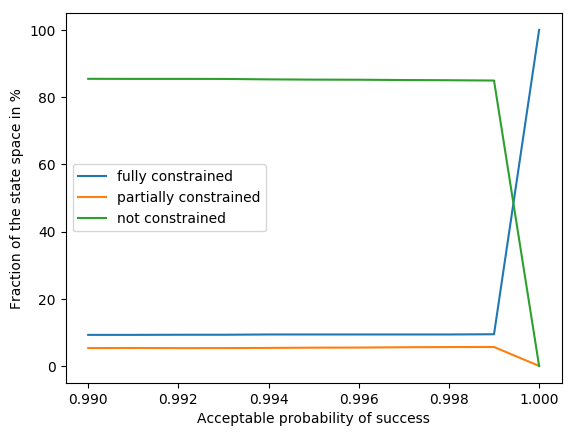

PyObject Text(24,0.5,'Fraction of the state space in %')

In [21]:
fig, ax = PyPlot.subplots(1)
ax[:plot](th_range, fc_parts)
ax[:plot](th_range, pc_parts)
ax[:plot](th_range, nc_parts)
ax[:legend](["fully constrained", "partially constrained", "not constrained"])
ax[:set_xlabel]("Acceptable probability of success")
ax[:set_ylabel]("Fraction of the state space in \%")

## Compare with Reward Based Approach

In [22]:
using DiscreteValueIteration

In [23]:
function POMDPs.actions(mdp::UnderlyingMDP{SingleOCPOMDP, SingleOCState, SingleOCAction}, s::SingleOCState)
    return get_safe_actions(mask, s)
end

solver = ValueIterationSolver(max_iterations = 1000)
masked_vi_policy = solve(solver, mdp, verbose=true);
val = ValuePolicy(mdp)
val.value_table = masked_vi_policy.qmat
masked_policy = MaskedValuePolicy(val, mask);

[Iteration 1   ] residual:          1 | iteration runtime:    780.371 ms, (      0.78 s total)
[Iteration 2   ] residual:       0.95 | iteration runtime:    987.259 ms, (      1.77 s total)
[Iteration 3   ] residual:      0.903 | iteration runtime:    789.908 ms, (      2.56 s total)
[Iteration 4   ] residual:      0.701 | iteration runtime:    850.647 ms, (      3.41 s total)
[Iteration 5   ] residual:      0.611 | iteration runtime:    634.412 ms, (      4.04 s total)
[Iteration 6   ] residual:      0.492 | iteration runtime:    695.055 ms, (      4.74 s total)
[Iteration 7   ] residual:      0.406 | iteration runtime:    699.464 ms, (      5.44 s total)
[Iteration 8   ] residual:      0.272 | iteration runtime:    686.001 ms, (      6.12 s total)
[Iteration 9   ] residual:      0.198 | iteration runtime:    668.958 ms, (      6.79 s total)
[Iteration 10  ] residual:      0.131 | iteration runtime:    680.968 ms, (      7.47 s total)
[Iteration 11  ] residual:     0.0938 | iteration 

In [24]:
solver = ValueIterationSolver(max_iterations = 1000)
vi_policy = solve(solver, pomdp, verbose=true);

[Iteration 1   ] residual:          1 | iteration runtime:   2669.416 ms, (      2.67 s total)
[Iteration 2   ] residual:       0.95 | iteration runtime:   2625.242 ms, (      5.29 s total)
[Iteration 3   ] residual:      0.903 | iteration runtime:   2597.701 ms, (      7.89 s total)
[Iteration 4   ] residual:      0.857 | iteration runtime:   3152.948 ms, (        11 s total)
[Iteration 5   ] residual:      0.811 | iteration runtime:   2824.319 ms, (      13.9 s total)
[Iteration 6   ] residual:      0.762 | iteration runtime:   2710.171 ms, (      16.6 s total)
[Iteration 7   ] residual:      0.707 | iteration runtime:   2780.311 ms, (      19.4 s total)
[Iteration 8   ] residual:      0.649 | iteration runtime:   2781.142 ms, (      22.1 s total)
[Iteration 9   ] residual:      0.539 | iteration runtime:   2873.524 ms, (        25 s total)
[Iteration 10  ] residual:      0.472 | iteration runtime:   2997.407 ms, (        28 s total)
[Iteration 11  ] residual:       0.42 | iteration 

In [56]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
@time hist = simulate(hr, mdp, masked_policy, s0);

  0.001568 seconds (22.06 k allocations: 723.445 KiB)


In [57]:
function animate_states(pomdp::SingleOCPOMDP, states::Vector{SingleOCState}, actions::Vector{SingleOCAction}, mask::SafetyMask;
                        overlays=SceneOverlay[IDOverlay()],
                        cam=StaticCamera(VecE2(25, -3.), 20.))
    duration = length(states)*pomdp.ΔT
    fps = Int(1/pomdp.ΔT)    
    function render_states(t, dt)
        frame_index = Int(floor(t/dt)) + 1
        scene = state_to_scene(pomdp, states[frame_index])
        safe_acts =[a.acc for a in get_safe_actions(mask, states[frame_index])]
        return AutoViz.render(scene,
                              pomdp.env,
                              cat(1, overlays, TextOverlay(text = ["Acc: $(actions[frame_index].acc)"],
                                                           font_size=20,
                                                           pos=VecE2(0.,8.),
                                                           incameraframe=true),
                                               TextOverlay(text = ["Available Actions: $safe_acts"],
                                                           font_size=20,
                                                           pos=VecE2(0.,10.),
                                                           incameraframe=true)),
                              cam=cam,
                              car_colors=get_colors(scene))
    end
    return duration, fps, render_states
end

animate_states (generic function with 1 method)

In [58]:
state_hist = hist.state_hist
action_hist = hist.action_hist
push!(action_hist, SingleOCAction(0.))
duration, fps, render_hist = animate_states(pomdp, state_hist, action_hist, mask)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpwYWp3r", 0x0000000000000010, 2.0, nothing)

## Evaluate Performance

In [28]:
function evaluation_loop(mdp::MDP, policy::Policy; n_ep::Int64 = 100, max_steps::Int64 = 200, rng::AbstractRNG = Base.GLOBAL_RNG)
    hr = HistoryRecorder(max_steps=max_steps, rng=rng)
    rewards = zeros(n_ep)
    steps = zeros(n_ep)
    for ep=1:n_ep
        s0 = initialstate(mdp, rng)
        hist = simulate(hr, mdp, policy, s0)
        rewards[ep] = discounted_reward(hist)
        steps[ep] = n_steps(hist)
    end
    return rewards, steps
end

evaluation_loop (generic function with 1 method)

In [29]:
n_ep = 10000
max_steps = 200
pol1 = vi_policy
pol2 = masked_policy

@time rewards1, steps1 = evaluation_loop(mdp, pol1, rng=rng, n_ep=n_ep, max_steps=max_steps)
@time rewards2, steps2 = evaluation_loop(mdp, pol2, rng=rng, n_ep=n_ep, max_steps=max_steps)

violations1 = sum(rewards1 .< 0.) #+ sum(steps1 .>= max_steps)
violations2 = sum(rewards2 .< 0.) #+ sum(steps2 .>= max_steps)
time_outs1 = sum(steps1 .>= max_steps)
time_outs2 = sum(steps2 .>= max_steps)
println("violations 1 ", violations1)
println("violations 2 ", violations2)

 25.659464 seconds (497.34 M allocations: 14.589 GiB, 26.13% gc time)
 68.847232 seconds (1.24 G allocations: 38.342 GiB, 25.29% gc time)
violations 1 44
violations 2 0


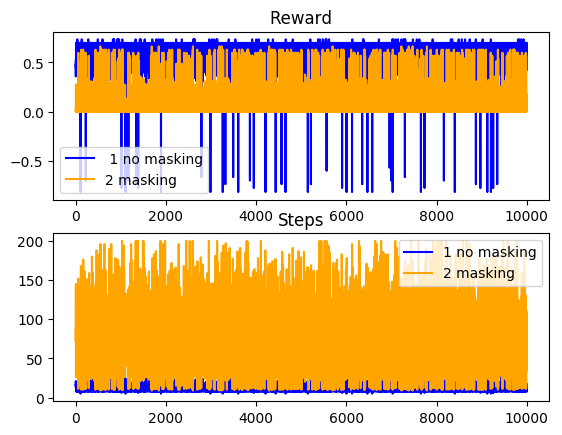

Mean Reward in 1: 0.5757710710590785
Mean Reward in 2: 0.07984193121656066
Mean Steps in 1: 11.8954
Mean Steps in 2: 74.561
% of violations in 1: 0.44
% of violations in 2: 0.0
time outs 1: 0
time outs 2: 34




PyObject Text(0.5,1,'Steps')

In [30]:
println("Mean Reward in 1: ", mean(rewards1))
println("Mean Reward in 2: ", mean(rewards2))
println("Mean Steps in 1: ", mean(steps1))
println("Mean Steps in 2: ", mean(steps2))
println("% of violations in 1: ", violations1/n_ep*100)
println("% of violations in 2: ", violations2/n_ep*100)
println("time outs 1: ", time_outs1)
println("time outs 2: ", time_outs2)
println("\n")


fig, axes = PyPlot.subplots(2, 1)
p1 = axes[1][:plot](rewards1, color="blue")
p2 = axes[1][:plot](rewards2, color="orange")
axes[1,1][:legend]([" 1 no masking", "2 masking"])
axes[1][:set_title]("Reward")


p1 = axes[2][:plot](steps1, color="blue")
p2 = axes[2][:plot](steps2, color="orange")
axes[2][:legend](["1 no masking", "2 masking"])
axes[2][:set_title]("Steps")


### Pareto fronts

In [49]:
collision_costs = [-1.,-10, -20, -30, -50]
goal_rewards = [1.]
n_ep = 10000
solver = ValueIterationSolver(max_iterations = 1000)
n_params =length(collision_costs)*length(goal_rewards)

5

In [50]:
threshold = 0.99
policy = Scheduler(mdp, result[:scheduler])
P = get_proba(mdp, result)
mask = SafetyMask(mdp, policy, P, threshold);

In [51]:
# compute Pareto front for masked policy
mask_r = zeros(n_params)
mask_steps = zeros(n_params)
mask_violations = zeros(n_params)
mask_params = zeros(n_params)
mask_reward_params = Vector{Tuple{Float64, Float64}}(n_params)
i = 1
for goal_reward in goal_rewards
    @showprogress for collision_cost in collision_costs
        mdp.pomdp.collision_cost = collision_cost
        mdp.pomdp.goal_reward = goal_reward
        solver = ValueIterationSolver(max_iterations = 1000)
        masked_vi_policy = solve(solver, mdp, verbose=false);
        val = ValuePolicy(mdp)
        val.value_table = masked_vi_policy.qmat
        masked_policy = MaskedValuePolicy(val, mask)
        rewards, steps = evaluation_loop(mdp, masked_policy, n_ep = n_ep, rng=rng)
        mask_r[i] = mean(rewards)
        mask_steps[i] = mean(steps)
        mask_violations[i] = mean(rewards .< 0.)
        mask_reward_params[i] = (goal_reward, collision_cost)
        i += 1
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:02


In [52]:
# compute Pareto front for the regular VI policy
nomask_r = zeros(n_params)
nomask_steps = zeros(n_params)
nomask_violations = zeros(n_params)
nomask_params = zeros(n_params)
nomask_reward_params = Vector{Tuple{Float64, Float64}}(n_params)
i = 1
for goal_reward in goal_rewards
    @showprogress for collision_cost in collision_costs
        pomdp.collision_cost = collision_cost
        pomdp.goal_reward = goal_reward
        solver = ValueIterationSolver(max_iterations = 1000)
        vi_policy = solve(solver, pomdp, verbose=false);
        rewards, steps = evaluation_loop(mdp, vi_policy, n_ep = n_ep, rng=rng)
        nomask_r[i] = mean(rewards)
        nomask_steps[i] = mean(steps)
        nomask_violations[i] = mean(rewards .< 0.)
        nomask_reward_params[i] = (goal_reward, collision_cost)
        i += 1
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:07:15


In [53]:
using JLD
JLD.save("nomask.jld", "nomask_r", nomask_r, "nomask_steps", nomask_steps, "nomask_violations", nomask_violations, "nomask_params", nomask_params)
JLD.save("mask.jld", "mask_r", mask_r, "mask_steps", mask_steps, "mask_violations", mask_violations, "mask_params", mask_params, "threshold", threshold)

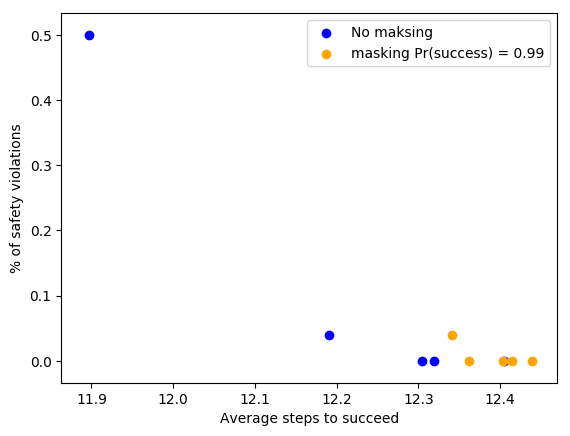

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f73d1aa0160>

In [55]:
fig, ax = PyPlot.subplots(1)
# ax[:plot](nomask_s, 100*(1-probability_of_success)*ones(length(mask_s)), color="black", linestyle="dashed")
# ax[:plot](nomask_s, 100*(1-threshold)*ones(length(mask_s)), color="green", linestyle="dashed")
ax[:scatter](nomask_steps, nomask_violations*100, color="blue")
# for i=1:length(nomask_steps)
# #     ax[:annotate](@sprintf("(%1.1f, %1.1f), %i", nomask_params[i][1], nomask_params[i][2], i),
# #                   xy=[nomask_steps[i]; nomask_violations[i]],
# #                   xycoords="data")
#         ax[:annotate](@sprintf(" %i", i),
#                   xy=[nomask_steps[i]; nomask_violations[i]+0.001],
#                   xycoords="data")
# end
ax[:scatter](mask_steps, mask_violations*100, color="orange")
# for i=1:length(mask_steps)
#         ax[:annotate](@sprintf(" %i", i),
#               xy=[mask_steps[i]; mask_violations[i]+0.001],
#               xycoords="data")
#     ax[:annotate](@sprintf("(%1.1f, %1.1f), %i", mask_params[i][1], mask_params[i][2], i),
#                   xy=[mask_steps[i]; mask_violations[i]],
#                   xycoords="data")
# end
ax[:set_ylabel]("% of safety violations")
ax[:set_xlabel]("Average steps to succeed")
# ax[:set_xlim](8, 33)
# ax[:set_ylim](-0.001, 0.01)
ax[:legend](["No maksing", "masking Pr(success) = $threshold"])
ax
# annotate points
# pareto front

# Try solving with tabular Q learning

In [10]:
using TabularTDLearning

In [14]:
solver = QLearningSolver(mdp, 
                         n_episodes=1000, 
                         learning_rate = 0.01, 
                         exp_policy = EpsGreedyPolicy(mdp, 0.9, rng=MersenneTwister(1)),
                         rng = MersenneTwister(1),
                         n_eval_traj = 100,
                         max_episode_length = 100,
                         log_eval = true)

ql_policy = solve(solver, mdp, verbose=true)

On Iteration 10, Returns: 0.0
On Iteration 20, Returns: 0.0
On Iteration 30, Returns: 0.0
On Iteration 40, Returns: 0.0
On Iteration 50, Returns: 0.0
On Iteration 60, Returns: 0.0
On Iteration 70, Returns: 0.0
On Iteration 80, Returns: 0.0
On Iteration 90, Returns: 0.0
On Iteration 100, Returns: 0.0
On Iteration 110, Returns: 0.0
On Iteration 120, Returns: 0.0
On Iteration 130, Returns: 0.0
On Iteration 140, Returns: 0.0
On Iteration 150, Returns: 0.0
On Iteration 160, Returns: 0.0
On Iteration 170, Returns: 0.0
On Iteration 180, Returns: 0.0
On Iteration 190, Returns: 0.0
On Iteration 200, Returns: 0.0
On Iteration 210, Returns: 0.0
On Iteration 220, Returns: 0.0
On Iteration 230, Returns: 0.0
On Iteration 240, Returns: 0.0
On Iteration 250, Returns: 0.0
On Iteration 260, Returns: 0.0
On Iteration 270, Returns: 0.0
On Iteration 280, Returns: 0.0
On Iteration 290, Returns: 0.0
On Iteration 300, Returns: 0.0
On Iteration 310, Returns: 0.0
On Iteration 320, Returns: 0.0
On Iteration 330,

POMDPToolbox.ValuePolicy{AutomotivePOMDPs.SingleOCAction,UnderlyingMDP{AutomotivePOMDPs.SingleOCPOMDP,AutomotivePOMDPs.SingleOCState,AutomotivePOMDPs.SingleOCAction}}(UnderlyingMDP{AutomotivePOMDPs.SingleOCPOMDP,AutomotivePOMDPs.SingleOCState,AutomotivePOMDPs.SingleOCAction}(AutomotivePOMDPs.SingleOCPOMDP(AutomotivePOMDPs.CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[], AutomotivePOMDPs.CrosswalkParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 100, 0.5, 2.0, 10.0)), VehicleDef(CAR, 4.000, 1.800), VehicleDef(PEDESTRIAN, 1.000, 1.000), 2.0, 1.0,

In [15]:
sim = RolloutSimulator(rng, 100)
s0 = initialstate(mdp, rng)
rtot = simulate(sim, mdp, ql_policy, s0)

0.0

In [55]:
function set_reward!(mdp::UnderlyingMDP{SingleOCPOMDP,SingleOCState,SingleOCAction}, collision_cost::Float64, goal_reward::Float64)
    set_reward!(mdp.pomdp, collision_cost, goal_reward)
end
function set_reward!(problem::SingleOCPOMDP, collision_cost::Float64, goal_reward::Float64)
    problem.collision_cost = collision_cost
    problem.goal_reward = goal_reward
end

function evaluate_rewards{P}(problem::P, solver::Solver, collision_costs::Vector{Float64}, goal_rewards::Vector{Float64}; n_ep::Int64 = 100, masking=false)
    n_val =length(collision_costs)*length(goal_rewards)
    avg_steps = zeros(length(collision_costs)*length(goal_rewards))
    avg_rewards = zeros(length(collision_costs)*length(goal_rewards))
    avg_violations = zeros(length(collision_costs)*length(goal_rewards))
    reward_params = Vector{Tuple{Float64, Float64}}(n_val)
    i = 1
    @showprogress for goal_reward in goal_rewards
        @showprogress for collision_cost in collision_costs
            set_reward!(problem, collision_cost, goal_reward)
            vi_pol = solve(solver, problem, verbose=false)
            mdp = nothing
            if isa(problem, POMDP)
                mdp = UnderlyingMDP(problem)
            else
                mdp = problem
            end
            if masking
                val = ValuePolicy(problem)
                val.value_table = vi_pol.qmat
                vi_pol = MaskedValuePolicy(val, mask)
            end
            rewards, steps = evaluation_loop(mdp, vi_policy, n_ep = n_ep, rng=rng)
            avg_rewards[i] = mean(rewards)
            avg_steps[i] = mean(steps)
            avg_violations[i] = mean(rewards .< 0.)
            reward_params[i] = (goal_reward, collision_cost)
            i += 1
        end
    end
    return avg_rewards, avg_steps, avg_violations, reward_params
end
        

evaluate_rewards (generic function with 3 methods)

In [61]:
collision_costs = [-1., -100]
goal_rewards = [1.]
n_ep = 10000
solver = ValueIterationSolver(max_iterations = 1000)

mask_r, mask_steps, mask_violations, mask_params = evaluate_rewards(mdp, solver, collision_costs, goal_rewards, n_ep=n_ep, masking=true)
nomask_r, nomask_steps, nomask_violations, nomask_params = evaluate_rewards(pomdp, solver, collision_costs, goal_rewards, n_ep=n_ep)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


([0.576333, 0.176605], [11.8816, 11.8156], [0.0043, 0.0054], Tuple{Float64,Float64}[(1.0, -1.0), (1.0, -100.0)])

In [71]:
mask_params[13]

(2.0, 0.0)

In [46]:
count = 0
for (i, s) in enumerate(states(pomdp))
    if length(get_safe_actions(mask, s)) < 4
        count += 1
        acts = [a.acc for a in get_safe_actions(mask, s)]
        println("state ", i, " safe actions ", acts)
    end
end

state 566 safe actions [-4.0, -2.0, 0.0]
state 567 safe actions [-4.0, -2.0, 0.0]
state 568 safe actions [-4.0, -2.0, 0.0]
state 569 safe actions [-4.0, -2.0, 0.0]
state 570 safe actions [-4.0, -2.0, 0.0]
state 571 safe actions [-4.0, -2.0, 0.0]
state 827 safe actions [-4.0, -2.0, 0.0]
state 828 safe actions [-4.0, -2.0, 0.0]
state 829 safe actions [-4.0, -2.0, 0.0]
state 830 safe actions [-4.0, -2.0, 0.0]
state 831 safe actions [-4.0, -2.0, 0.0]
state 832 safe actions [-4.0, -2.0, 0.0]
state 833 safe actions [-4.0, -2.0, 0.0]
state 834 safe actions [-4.0, -2.0, 0.0]
state 835 safe actions [-4.0, -2.0, 0.0]
state 836 safe actions [-4.0, -2.0, 0.0]
state 837 safe actions [-4.0, -2.0, 0.0]
state 838 safe actions [-4.0, -2.0, 0.0]
state 860 safe actions [-4.0, -2.0]
state 861 safe actions [-4.0, -2.0]
state 862 safe actions [-4.0, -2.0]
state 863 safe actions [-4.0, -2.0]
state 864 safe actions [-4.0, -2.0]
state 865 safe actions [-4.0, -2.0]
state 866 safe actions [-4.0, -2.0]
state 867 

state 2354 safe actions [-4.0]
state 2355 safe actions [-4.0]
state 2356 safe actions [-4.0]
state 2357 safe actions [-4.0]
state 2358 safe actions [-4.0]
state 2359 safe actions [-4.0]
state 2360 safe actions [-4.0]
state 2361 safe actions [-4.0]
state 2362 safe actions [-4.0]
state 2546 safe actions [-4.0, -2.0, 0.0]
state 2547 safe actions [-4.0, -2.0, 0.0]
state 2548 safe actions [-4.0, -2.0, 0.0]
state 2549 safe actions [-4.0, -2.0, 0.0]
state 2550 safe actions [-4.0, -2.0, 0.0]
state 2551 safe actions [-4.0, -2.0, 0.0]
state 2552 safe actions [-4.0, -2.0, 0.0]
state 2553 safe actions [-4.0, -2.0, 0.0]
state 2554 safe actions [-4.0, -2.0, 0.0]
state 2555 safe actions [-4.0, -2.0, 0.0]
state 2556 safe actions [-4.0, -2.0, 0.0]
state 2557 safe actions [-4.0, -2.0, 0.0]
state 2558 safe actions [-4.0, -2.0, 0.0]
state 2559 safe actions [-4.0, -2.0, 0.0]
state 2560 safe actions [-4.0, -2.0, 0.0]
state 2579 safe actions [-4.0, -2.0]
state 2580 safe actions [-4.0, -2.0]
state 2581 safe a

state 3476 safe actions [-4.0]
state 3477 safe actions [-4.0]
state 3478 safe actions [-4.0]
state 3479 safe actions [-4.0]
state 3480 safe actions [-4.0]
state 3481 safe actions [-4.0]
state 3482 safe actions [-4.0]
state 3483 safe actions [-4.0]
state 3484 safe actions [-4.0]
state 3503 safe actions [-2.0, 0.0, 2.0]
state 3504 safe actions [-2.0, 0.0, 2.0]
state 3505 safe actions [-2.0, 0.0, 2.0]
state 3506 safe actions [2.0]
state 3507 safe actions [2.0]
state 3508 safe actions [2.0]
state 3509 safe actions [2.0]
state 3510 safe actions [2.0]
state 3511 safe actions [2.0]
state 3512 safe actions [2.0]
state 3513 safe actions [2.0]
state 3514 safe actions [2.0]
state 3515 safe actions [2.0]
state 3516 safe actions [2.0]
state 3517 safe actions [2.0]
state 3539 safe actions [2.0]
state 3540 safe actions [2.0]
state 3541 safe actions [2.0]
state 3542 safe actions [0.0]
state 3543 safe actions [0.0]
state 3544 safe actions [0.0]
state 3545 safe actions [0.0]
state 3546 safe actions [0.0

state 4237 safe actions [-4.0, -2.0]
state 4238 safe actions [-4.0, -2.0]
state 4239 safe actions [-4.0, -2.0]
state 4240 safe actions [-4.0, -2.0]
state 4241 safe actions [-4.0, -2.0]
state 4242 safe actions [-4.0, -2.0]
state 4243 safe actions [-4.0, -2.0]
state 4259 safe actions [-4.0, 0.0, 2.0]
state 4260 safe actions [-4.0, 0.0, 2.0]
state 4261 safe actions [-4.0, 0.0, 2.0]
state 4262 safe actions [-4.0]
state 4263 safe actions [-4.0]
state 4264 safe actions [-4.0]
state 4265 safe actions [-4.0]
state 4266 safe actions [-4.0]
state 4267 safe actions [-4.0]
state 4268 safe actions [-4.0]
state 4269 safe actions [-4.0]
state 4270 safe actions [-4.0]
state 4271 safe actions [-4.0]
state 4272 safe actions [-4.0]
state 4273 safe actions [-4.0]
state 4274 safe actions [-4.0]
state 4275 safe actions [-4.0]
state 4276 safe actions [-4.0]
state 4292 safe actions [-2.0, 0.0, 2.0]
state 4293 safe actions [-2.0, 0.0, 2.0]
state 4294 safe actions [-2.0, 0.0, 2.0]
state 4295 safe actions [0.0, 

state 4803 safe actions [-4.0]
state 4804 safe actions [-4.0]
state 4805 safe actions [-4.0]
state 4806 safe actions [-4.0]
state 4817 safe actions [-2.0, 0.0, 2.0]
state 4818 safe actions [-2.0, 0.0, 2.0]
state 4819 safe actions [-2.0, 0.0, 2.0]
state 4820 safe actions [0.0, 2.0]
state 4821 safe actions [0.0, 2.0]
state 4822 safe actions [0.0, 2.0]
state 4823 safe actions [2.0]
state 4824 safe actions [2.0]
state 4825 safe actions [2.0]
state 4826 safe actions [2.0]
state 4827 safe actions [2.0]
state 4828 safe actions [2.0]
state 4829 safe actions [-4.0]
state 4830 safe actions [-4.0]
state 4831 safe actions [-4.0]
state 4832 safe actions [-4.0]
state 4833 safe actions [-4.0]
state 4834 safe actions [-4.0]
state 4835 safe actions [-4.0]
state 4836 safe actions [-4.0]
state 4837 safe actions [-4.0]
state 4838 safe actions [-4.0]
state 4839 safe actions [-4.0]
state 4853 safe actions [-2.0, 0.0, 2.0]
state 4854 safe actions [-2.0, 0.0, 2.0]
state 4855 safe actions [-2.0, 0.0, 2.0]
stat

state 5458 safe actions [-4.0]
state 5459 safe actions [-4.0]
state 5460 safe actions [-4.0]
state 5461 safe actions [-4.0]
state 5462 safe actions [-4.0]
state 5463 safe actions [-4.0]
state 5464 safe actions [-4.0]
state 5465 safe actions [-4.0]
state 5466 safe actions [-4.0]
state 5489 safe actions [0.0, 2.0]
state 5490 safe actions [0.0, 2.0]
state 5491 safe actions [-4.0]
state 5492 safe actions [-4.0]
state 5493 safe actions [-4.0]
state 5494 safe actions [-4.0]
state 5495 safe actions [-4.0]
state 5496 safe actions [-4.0]
state 5497 safe actions [-4.0]
state 5498 safe actions [-4.0]
state 5499 safe actions [-4.0]
state 5524 safe actions [-4.0]
state 5525 safe actions [-4.0]
state 5526 safe actions [-4.0]
state 5527 safe actions [-4.0]
state 5528 safe actions [-4.0]
state 5529 safe actions [-4.0]
state 5530 safe actions [-4.0]
state 5531 safe actions [-4.0]
state 5532 safe actions [-4.0]
state 5557 safe actions [-4.0]
state 5558 safe actions [-4.0]
state 5559 safe actions [-4.0]


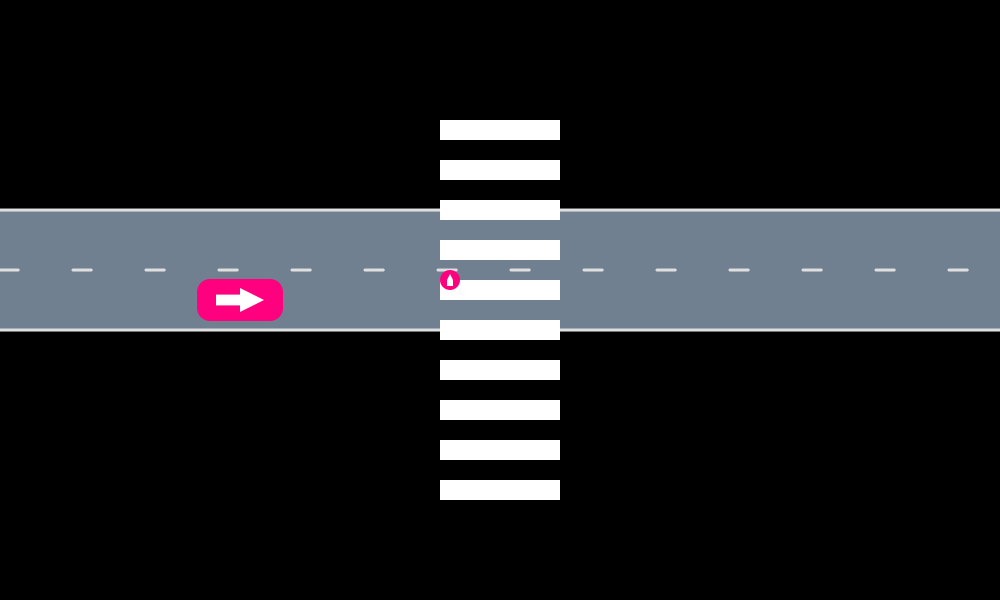

In [66]:
s = state_to_scene(pomdp, states(pomdp)[2329])
render(s, env, cam=FitToContentCamera(0.))

In [48]:
count/n_states(pomdp)*100

14.547435135670431

## Code Profiling

In [25]:
using ProfileView

In [44]:
hr = HistoryRecorder(rng=rng, max_steps=100)
s0 = initialstate(mdp, rng)
@profile hist = simulate(hr, mdp, policy, s0);

08-May 13:10:28:WARNING:root:The profile data buffer is full; profiling probably terminated
before your program finished. To profile for longer runs, call Profile.init
with a larger buffer and/or larger delay.


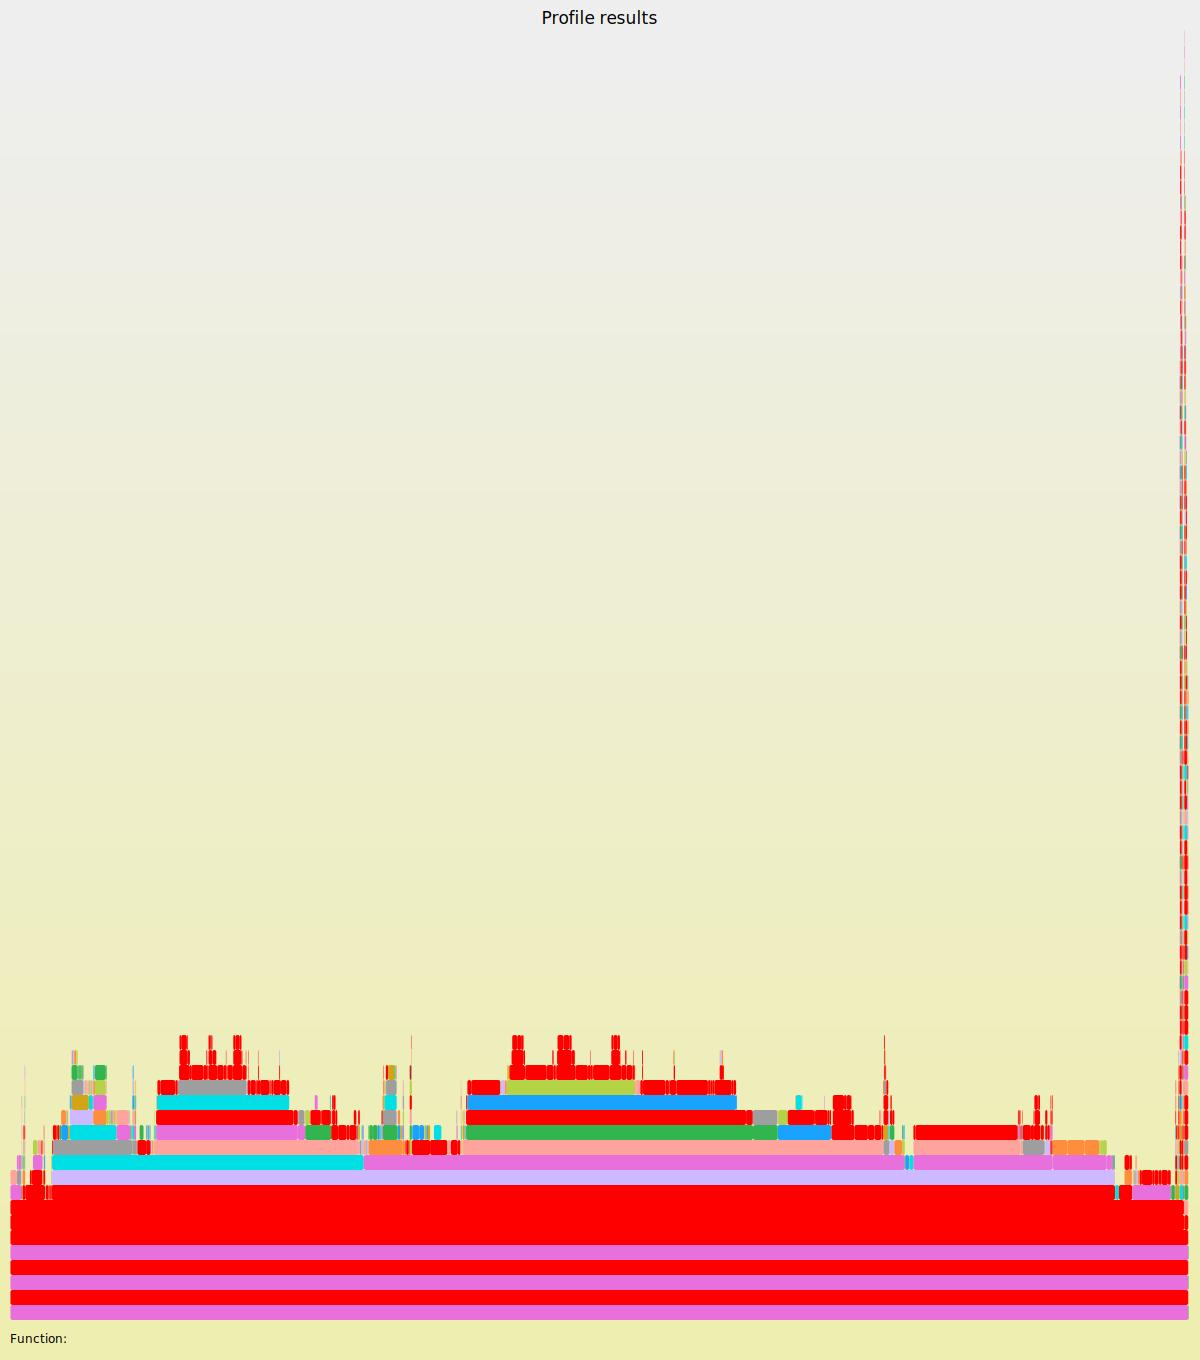

In [26]:
ProfileView.view()